#  Training a SSD MobileNet V2 for Pedestrian Detection with TLT

This notebook shows how to train a SSD MobileNet V2 object detector for pedestrian detection with [Nvidia's Transfer Learning Toolkit](https://developer.nvidia.com/transfer-learning-toolkit).
TLT is a useful tool for train classification and object detection models with various pretrained backbone. The trained models with TLT can be easily integrate and deploy to DeepStream.
Note that this notebook and specs files are just a modification of examples that exist on the [TLT docker container](https://ngc.nvidia.com/catalog/containers/nvidia:tlt-streamanalytics).

0. [Set up env variables](#head-0)
1. [Prepare dataset and pre-trained model](#head-1) <br>
    1.1 [Prepare tfrecords from kitti format dataset](#head-1-1) <br>
    1.2 [Download pre-trained model](#head-1-2) <br>
2. [Provide training specification](#head-2)
3. [Run TLT training](#head-3)
4. [Evaluate trained models](#head-4)
5. [Prune trained models](#head-5)
6. [Retrain pruned models](#head-6)
7. [Evaluate retrained model](#head-7)
8. [Visualize inferences](#head-8)
9. [Deploy](#head-9)

## 0. Set up env variables <a class="anchor" id="head-0"></a>


In [1]:
# Setting up env variables for cleaner command line commands.
print("Please replace the variable with your key.")
%set_env KEY=[YOUR NGC API KEY]
%set_env USER_EXPERIMENT_DIR=/experiment_dir/ped_ssd_mobilenet_v2
%set_env DATASET_DIR=/experiment_dir/dataset
%set_env SPECS_DIR=/repo/training/tlt/pedestrian_detection/specs
%set_env TF_FORCE_GPU_ALLOW_GROWTH=true
!mkdir -p $USER_EXPERIMENT_DIR

Please replace the variable with your key.
env: KEY=MzYwbm5pcGpxdmRxMHA1cjN2cnJodGtrYXE6YTJmMjE4MWEtM2E0Ni00MzhkLWI2YTItOWU0YzQ2MzRlZTgy
env: USER_EXPERIMENT_DIR=/experiment_dir/ped_ssd_mobilenet_v2
env: DATASET_DIR=/experiment_dir/dataset
env: SPECS_DIR=/repo/training/tlt/specs


## 1. Prepare dataset and pre-trained model <a class="anchor" id="head-1"></a>

We will be using [Oxford Town Center Dataset](https://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/project.html) for training our pedestrian detection. First we will download the video file and annotatoin `csv` file with `download_towncenter_video_and_labels.sh` script and then create images and kitti format annotation files with `extract_images.py` and `extract_kitti_labels.py` scripts. note that TLT will not perform dynamic resizing in training time and every image should be resize to a certain size offline (for SSD detectord the width and height of images should be a multiply of 32). Also for training object detectors the annotations should be in KITTI format. for further information about creating KITTI format annotations checkout [TLT getting started guide](https://docs.nvidia.com/metropolis/TLT/tlt-getting-started-guide/index.html)

In [4]:
# Download Oxford Town Center Dataset video file and csv annotation file
!bash ./download_towncenter_video_and_labels.sh

mkdir: cannot create directory ‘/experiment_dir/dataset’: File exists
--2020-05-19 18:13:10--  http://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentreXVID.avi
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147486436 (141M) [video/x-msvideo]
Saving to: ‘/experiment_dir/dataset/TownCentreXVID.avi’

/experiment_dir/dat 100%[===================>] 140.65M  4.14MB/s    in 28s     

2020-05-19 18:13:39 (5.05 MB/s) - ‘/experiment_dir/dataset/TownCentreXVID.avi’ saved [147486436/147486436]

--2020-05-19 18:13:39--  https://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentre-groundtruth.top
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request

In [9]:
# Extract images from video, resize them and save in images directory 
!python3 extract_images.py --video_path $DATASET_DIR/TownCentreXVID.avi --image_width 320 --image_height 320

==================== Start Reading Video ! ====================


In [10]:
# Create KITTI annotation file and save in labels directory
!python3 extract_kitti_labels.py --annotation_path $DATASET_DIR/TownCentre-groundtruth.top --image_width 320 --image_height 320

==================== Start Preparing Annotations in Kitti Format ! ====================


In [19]:
# verify
!ls -lh $DATASET_DIR/

total 147M
-rw-r--r-- 1 root root 5.3M May 19  2011 TownCentre-groundtruth.top
-rw-r--r-- 1 root root 141M Oct 30  2011 TownCentreXVID.avi
drwxr-xr-x 2 root root 120K May 19 18:22 images
drwxr-xr-x 2 root root 116K May 19 18:24 labels


### 1.1 Prepare tfrecords from kitti format dataset <a class="anchor" id="head-1-1"></a>

* Update the tfrecords spec file to take in your kitti format dataset
* Create the tfrecords using the tlt-dataset-convert 
* TFRecords only need to be generated once.

In [29]:
print("TFrecords conversion spec file for training")
!cat $SPECS_DIR/ssd_tfrecords_towncenter_trainval.txt

TFrecords conversion spec file for training
kitti_config {
  root_directory_path: "/experiment_dir/dataset"
  image_dir_name: "images"
  label_dir_name: "labels"
  image_extension: ".jpg"
  partition_mode: "random"
  num_partitions: 2
  val_split: 14
  num_shards: 10
}
image_directory_path: "/experiment_dir/dataset"


In [30]:
# Creating a new directory for the output tfrecords dump.
# !mkdir -p $USER_EXPERIMENT_DIR/tfrecords
#KITTI trainval
!tlt-dataset-convert -d $SPECS_DIR/ssd_tfrecords_towncenter_trainval.txt \
                     -o $DATA_DOWNLOAD_DIR/tfrecords/

Using TensorFlow backend.
2020-05-19 18:42:56,212 - iva.detectnet_v2.dataio.build_converter - INFO - Instantiating a kitti converter
2020-05-19 18:42:56,213 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Creating output directory /tfrecords
2020-05-19 18:42:56,221 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Num images in
Train: 3871	Val: 630
2020-05-19 18:42:56,221 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Validation data in partition 0. Hence, while choosing the validationset during training choose validation_fold 0.
2020-05-19 18:42:56,222 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 0, shard 0
/usr/local/lib/python2.7/dist-packages/iva/detectnet_v2/dataio/kitti_converter_lib.py:266: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
2020-05-19 18:42:56,288 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Wr

In [33]:
!ls -rlt $DATASET_DIR/tfrecords/

total 6956
-rw-r--r-- 1 root root 101813 May 19 18:35 -fold-000-of-002-shard-00000-of-00010
-rw-r--r-- 1 root root  99601 May 19 18:35 -fold-000-of-002-shard-00001-of-00010
-rw-r--r-- 1 root root  97923 May 19 18:35 -fold-000-of-002-shard-00002-of-00010
-rw-r--r-- 1 root root 100609 May 19 18:35 -fold-000-of-002-shard-00003-of-00010
-rw-r--r-- 1 root root  97446 May 19 18:35 -fold-000-of-002-shard-00004-of-00010
-rw-r--r-- 1 root root  98696 May 19 18:35 -fold-000-of-002-shard-00005-of-00010
-rw-r--r-- 1 root root 100370 May 19 18:35 -fold-000-of-002-shard-00006-of-00010
-rw-r--r-- 1 root root  99646 May 19 18:35 -fold-000-of-002-shard-00007-of-00010
-rw-r--r-- 1 root root  99413 May 19 18:35 -fold-000-of-002-shard-00008-of-00010
-rw-r--r-- 1 root root 102227 May 19 18:35 -fold-000-of-002-shard-00009-of-00010
-rw-r--r-- 1 root root 614676 May 19 18:35 -fold-001-of-002-shard-00000-of-00010
-rw-r--r-- 1 root root 606124 May 19 18:35 -fold-001-of-002-shard-00001-of-00010
-rw-r--r-- 1 root

### 1.2 Download pre-trained model <a class="anchor" id="head-1-2"></a>

We will use NGC CLI to get the pre-trained models. For more details, go to [ngc.nvidia.com](ngc.nvidia.com) and click the SETUP on the navigation bar.

In [34]:
!ngc registry model list nvidia/tlt_pretrained_object_detection:*

+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File  | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size  | s     | ed    |
|       |       |       |       |       | tprin |       |       | Date  |
|       |       |       |       |       | t     |       |       |       |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| resne | 74.38 | 80    | 1     | V100  | 38.3  | 38.31 | UPLOA | Apr   |
| t10   |       |       |       |       |       | MB    | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| resne | 76.74 | 80    | 1     | V100  | 89.0  | 88.96 | UPLOA | Apr   |
| t18   |       |       |       |       |       | MB    | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| resne | 77.04 | 80    | 1     | V100  | 170.7 | 170.6 | UPLOA | Apr   |
| t34   |       |       |       |     

In [35]:
!mkdir -p $USER_EXPERIMENT_DIR/pretrained_mobilenet_v2/

In [36]:
# Pull pretrained model from NGC
!ngc registry model download-version nvidia/tlt_pretrained_object_detection:mobilenet_v2 --dest $USER_EXPERIMENT_DIR/pretrained_mobilenet_v2

Downloaded 4.3 MB in 2s, Download speed: 2.15 MB/s               
----------------------------------------------------
Transfer id: tlt_pretrained_object_detection_vmobilenet_v2 Download status: Completed.
Downloaded local path: /experiment_dir/ped_ssd_mobilenet_v2/pretrained_mobilenet_v2/tlt_pretrained_object_detection_vmobilenet_v2
Total files downloaded: 1 
Total downloaded size: 4.3 MB
Started at: 2020-05-19 19:26:37.985342
Completed at: 2020-05-19 19:26:39.988655
Duration taken: 2s
----------------------------------------------------


In [37]:
print("Check that model is downloaded into dir.")
!ls -lh $USER_EXPERIMENT_DIR/pretrained_mobilenet_v2/tlt_pretrained_object_detection_vmobilenet_v2

Check that model is downloaded into dir.
total 5.1M
-rw------- 1 root root 5.1M May 19 19:26 mobilenet_v2.hdf5


## 2. Provide training specification <a class="anchor" id="head-2"></a>
* Tfrecords for the train datasets
    * In order to use the newly generated tfrecords, update the dataset_config parameter in the spec file at `$SPECS_DIR/ssd_train_resnet18_kitti.txt` 
    * Update the fold number to use for evaluation. In case of random data split, please use fold 0 only
    * For sequence wise you may use any fold generated from the dataset convert tool
* Pre-trained models
* Augmentation parameters for on the fly data augmentation
* Other training (hyper-)parameters such as batch size, number of epochs, learning rate etc.

In [39]:
!cat $SPECS_DIR/ped_ssd_mobilenet_v2_train.txt

random_seed: 42
ssd_config {
  aspect_ratios_global: "[1.0, 2.0, 0.5, 3.0, 1.0/3.0]"
  scales: "[0.1, 0.24166667, 0.38333333, 0.525, 0.66666667, 0.80833333, 0.95]"
  two_boxes_for_ar1: true
  clip_boxes: false
  loss_loc_weight: 1.0
  focal_loss_alpha: 0.25
  focal_loss_gamma: 2.0
  variances: "[0.1, 0.1, 0.2, 0.2]"
  arch: "mobilenet_v2"
  freeze_bn: false
}
training_config {
  batch_size_per_gpu: 16
  num_epochs: 250
  learning_rate {
  soft_start_annealing_schedule {
    min_learning_rate: 5e-5
    max_learning_rate: 2e-2
    soft_start: 0.15
    annealing: 0.5
    }
  }
  regularizer {
    type: L1
    weight: 3e-06
  }
}
eval_config {
  validation_period_during_training: 10
  average_precision_mode: SAMPLE
  batch_size: 32
  matching_iou_threshold: 0.5
}
nms_config {
  confidence_threshold: 0.01
  clustering_iou_threshold: 0.6
  top_k: 200
}
augmentation_config {
  preprocessing {
    output_image_width: 320
    output_image_height: 320
    output_image_channel: 3
    crop_right: 

## 3. Run TLT training <a class="anchor" id="head-3"></a>
* Provide the sample spec file and the output directory location for models
* WARNING: training will take several hours or one day to complete

In [40]:
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_unpruned

In [41]:
print("To run with multigpu, please change --gpus based on the number of available GPUs in your machine.")
!tlt-train ssd -e $SPECS_DIR/ped_ssd_mobilenet_v2_train.txt \
               -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned \
               -k $KEY \
               -m $USER_EXPERIMENT_DIR/pretrained_mobilenet_v2/tlt_pretrained_object_detection_vmobilenet_v2/mobilenet_v2.hdf5 \
               --gpus 1

To run with multigpu, please change --gpus based on the number of available GPUs in your machine.
Using TensorFlow backend.
2020-05-19 19:32:00,398 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /repo/training/tlt/specs/ped_ssd_mobilenet_v2_train.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target

Epoch 1/250
242/242 [==============================] - 63s 260ms/step - loss: 29.1518

Epoch 00001: saving model to /experiment_dir/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_001.tlt
Epoch 2/250
242/242 [==============================] - 53s 218ms/step - loss: 4.7322

Epoch 00002: saving model to /experiment_dir/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_002.tlt
Epoch 3/250
242/242 [==============================] - 53s 218ms/step - loss: 3.9978

Epoch 00003: saving model to /experiment_dir/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_003.tlt
Epoch 4/250
242/242 [==============================] - 53s 218ms/step - loss: 3.6337

Epoch 00004: saving model to /experiment_dir/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_004.tlt
Epoch 5/250
242/242 [==============================] - 53s 218ms/step - loss: 3.4095

Epoch 00005: saving model to /experiment_dir/ped_ssd_

242/242 [==============================] - 53s 220ms/step - loss: 1.1791

Epoch 00035: saving model to /experiment_dir/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_035.tlt
Epoch 36/250
242/242 [==============================] - 53s 220ms/step - loss: 1.1553

Epoch 00036: saving model to /experiment_dir/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_036.tlt
Epoch 37/250
242/242 [==============================] - 53s 221ms/step - loss: 1.1364

Epoch 00037: saving model to /experiment_dir/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_037.tlt
Epoch 38/250
242/242 [==============================] - 53s 220ms/step - loss: 1.1238

Epoch 00038: saving model to /experiment_dir/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_038.tlt
Epoch 39/250
242/242 [==============================] - 53s 220ms/step - loss: 1.0869

Epoch 00039: saving model to /experiment_dir/ped_ssd_mobilenet

In [42]:
print('Model for each epoch:')
print('---------------------')
!ls -ltrh $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights

Model for each epoch:
---------------------
total 306M
-rw-r--r-- 1 root root 4.9M May 19 19:40 ssd_mobilenet_v2_epoch_001.tlt
-rw-r--r-- 1 root root 4.9M May 19 19:40 ssd_mobilenet_v2_epoch_002.tlt
-rw-r--r-- 1 root root 4.9M May 19 19:41 ssd_mobilenet_v2_epoch_003.tlt
-rw-r--r-- 1 root root 4.9M May 19 19:42 ssd_mobilenet_v2_epoch_004.tlt
-rw-r--r-- 1 root root 4.9M May 19 19:43 ssd_mobilenet_v2_epoch_005.tlt
-rw-r--r-- 1 root root 4.9M May 19 19:44 ssd_mobilenet_v2_epoch_006.tlt
-rw-r--r-- 1 root root 4.9M May 19 19:45 ssd_mobilenet_v2_epoch_007.tlt
-rw-r--r-- 1 root root 4.9M May 19 19:46 ssd_mobilenet_v2_epoch_008.tlt
-rw-r--r-- 1 root root 4.9M May 19 19:47 ssd_mobilenet_v2_epoch_009.tlt
-rw-r--r-- 1 root root 4.9M May 19 19:48 ssd_mobilenet_v2_epoch_010.tlt
-rw-r--r-- 1 root root 4.9M May 19 19:49 ssd_mobilenet_v2_epoch_011.tlt
-rw-r--r-- 1 root root 4.9M May 19 19:50 ssd_mobilenet_v2_epoch_012.tlt
-rw-r--r-- 1 root root 4.9M May 19 19:50 ssd_mobilenet_v2_epoch_013.tlt
-rw-r--r-

In [43]:
# Now check the evaluation stats in the csv file and pick the model with highest eval accuracy.
# Note csv epoch number is 1 less than model file epoch. For example, epoch 79 in csv corresponds to _080.tlt
!cat $USER_EXPERIMENT_DIR/experiment_dir_unpruned/ssd_training_log_mobilenet_v2.csv

In [48]:
# Set the epoch number which has best performance
%set_env EPOCH=060

env: EPOCH=060


## 4. Evaluate trained models <a class="anchor" id="head-4"></a>

In [49]:
!tlt-evaluate ssd -e $SPECS_DIR/ped_ssd_mobilenet_v2_train.txt \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
                  -k $KEY

Using TensorFlow backend.
2020-05-19 20:41:18,198 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /repo/training/tlt/specs/ped_ssd_mobilenet_v2_train.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target

## 5. Prune trained models <a class="anchor" id="head-5"></a>
* Specify pre-trained model
* Equalization criterion (`Only for resnets as they have element wise operations or MobileNets.`)
* Threshold for pruning.
* A key to save and load the model
* Output directory to store the model

Usually, you just need to adjust `-pth` (threshold) for accuracy and model size trade off. Higher `pth` gives you smaller model (and thus higher inference speed) but worse accuracy. The threshold value depends on the dataset and the model. `0.5` in the block below is just a start point. If the retrain accuracy is good, you can increase this value to get smaller models. Otherwise, lower this value to get better accuracy.

In [50]:
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_pruned

In [51]:
!tlt-prune -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
           -o $USER_EXPERIMENT_DIR/experiment_dir_pruned/ssd_mobilenet_v2_pruned.tlt \
           -eq intersection \
           -pth 0.5 \
           -k $KEY

Using TensorFlow backend.
2020-05-19 20:42:36,690 [INFO] modulus.pruning.pruning: Exploring graph for retainable indices
2020-05-19 20:42:38,392 [INFO] modulus.pruning.pruning: Pruning model and appending pruned nodes to new graph
2020-05-19 20:43:54,413 [INFO] iva.common.magnet_prune: Pruning ratio (pruned model / original model): 0.626073393914


In [52]:
!ls -rlt $USER_EXPERIMENT_DIR/experiment_dir_pruned/

total 3304
-rw-r--r-- 1 root root 3380104 May 19 20:43 ssd_mobilenet_v2_pruned.tlt


## 6. Retrain pruned models <a class="anchor" id="head-6"></a>
* Model needs to be re-trained to bring back accuracy after pruning
* Specify re-training specification
* WARNING: training will take several hours or one day to complete

In [55]:
# Printing the retrain spec file. 
# Here we have updated the spec file to include the newly pruned model as a pretrained weights.
!cat $SPECS_DIR/ped_ssd_mobilenet_v2_retrain.txt

random_seed: 42
ssd_config {
  aspect_ratios_global: "[1.0, 2.0, 0.5, 3.0, 1.0/3.0]"
  scales: "[0.1, 0.24166667, 0.38333333, 0.525, 0.66666667, 0.80833333, 0.95]"
  two_boxes_for_ar1: true
  clip_boxes: false
  loss_loc_weight: 1.0
  focal_loss_alpha: 0.25
  focal_loss_gamma: 2.0
  variances: "[0.1, 0.1, 0.2, 0.2]"
  arch: "mobilenet_v2"
  freeze_bn: false
}
training_config {
  batch_size_per_gpu: 16
  num_epochs: 250
  learning_rate {
  soft_start_annealing_schedule {
    min_learning_rate: 5e-5
    max_learning_rate: 2e-2
    soft_start: 0.1
    annealing: 0.3
    }
  }
  regularizer {
    type: L1
    weight: 3.00000002618e-09
  }
}
eval_config {
  validation_period_during_training: 10
  average_precision_mode: SAMPLE
  batch_size: 32
  matching_iou_threshold: 0.5
}
nms_config {
  confidence_threshold: 0.01
  clustering_iou_threshold: 0.6
  top_k: 200
}
augmentation_config {
  preprocessing {
    output_image_width: 320
    output_image_height: 320
    output_image_channel: 3
    c

In [56]:
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_retrain

In [57]:
# Retraining using the pruned model as pretrained weights 
!tlt-train ssd --gpus 1 \
               -e $SPECS_DIR/ped_ssd_mobilenet_v2_retrain.txt \
               -r $USER_EXPERIMENT_DIR/experiment_dir_retrain \
               -m $USER_EXPERIMENT_DIR/experiment_dir_pruned/ssd_mobilenet_v2_pruned.tlt \
               -k $KEY

Using TensorFlow backend.
2020-05-19 20:51:52,224 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /repo/training/tlt/specs/ped_ssd_mobilenet_v2_retrain.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
targ

Epoch 1/250
242/242 [==============================] - 48s 198ms/step - loss: 3.5010

Epoch 00001: saving model to /experiment_dir/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_001.tlt
Epoch 2/250
242/242 [==============================] - 40s 164ms/step - loss: 2.3405

Epoch 00002: saving model to /experiment_dir/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_002.tlt
Epoch 3/250
242/242 [==============================] - 40s 165ms/step - loss: 1.9773

Epoch 00003: saving model to /experiment_dir/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_003.tlt
Epoch 4/250
242/242 [==============================] - 40s 165ms/step - loss: 1.7780

Epoch 00004: saving model to /experiment_dir/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_004.tlt
Epoch 5/250
242/242 [==============================] - 40s 165ms/step - loss: 1.6573

Epoch 00005: saving model to /experiment_dir/ped_ssd_mobil

242/242 [==============================] - 40s 165ms/step - loss: 0.8012

Epoch 00035: saving model to /experiment_dir/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_035.tlt
Epoch 36/250
239/242 [============================>.] - ETA: 0s - loss: 0.7951^C
Traceback (most recent call last):
  File "/usr/local/bin/tlt-train-g1", line 8, in <module>
    sys.exit(main())
  File "./common/magnet_train.py", line 37, in main
  File "./ssd/scripts/train.py", line 245, in main
  File "./ssd/scripts/train.py", line 182, in run_experiment
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/training.py", line 1039, in fit
    validation_steps=validation_steps)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/training_arrays.py", line 154, in fit_loop
    outs = f(ins)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 2715, in __call__
    return self._call(inputs)
  File "/usr/local/lib/python2.7/dist-packages/ke

In [58]:
# Listing the newly retrained model.
!ls -rlht $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights

total 113M
-rw-r--r-- 1 root root 3.3M May 19 20:55 ssd_mobilenet_v2_epoch_001.tlt
-rw-r--r-- 1 root root 3.3M May 19 20:56 ssd_mobilenet_v2_epoch_002.tlt
-rw-r--r-- 1 root root 3.3M May 19 20:57 ssd_mobilenet_v2_epoch_003.tlt
-rw-r--r-- 1 root root 3.3M May 19 20:57 ssd_mobilenet_v2_epoch_004.tlt
-rw-r--r-- 1 root root 3.3M May 19 20:58 ssd_mobilenet_v2_epoch_005.tlt
-rw-r--r-- 1 root root 3.3M May 19 20:59 ssd_mobilenet_v2_epoch_006.tlt
-rw-r--r-- 1 root root 3.3M May 19 20:59 ssd_mobilenet_v2_epoch_007.tlt
-rw-r--r-- 1 root root 3.3M May 19 21:00 ssd_mobilenet_v2_epoch_008.tlt
-rw-r--r-- 1 root root 3.3M May 19 21:01 ssd_mobilenet_v2_epoch_009.tlt
-rw-r--r-- 1 root root 3.3M May 19 21:01 ssd_mobilenet_v2_epoch_010.tlt
-rw-r--r-- 1 root root 3.3M May 19 21:02 ssd_mobilenet_v2_epoch_011.tlt
-rw-r--r-- 1 root root 3.3M May 19 21:03 ssd_mobilenet_v2_epoch_012.tlt
-rw-r--r-- 1 root root 3.3M May 19 21:04 ssd_mobilenet_v2_epoch_013.tlt
-rw-r--r-- 1 root root 3.3M May 19 21:04 ssd_mobilene

In [59]:
# Now check the evaluation stats in the csv file and pick the model with highest eval accuracy.
# Note csv epoch number is 1 less than model file epoch. For example, epoch 79 in csv corresponds to _080.tlt
!cat $USER_EXPERIMENT_DIR/experiment_dir_retrain/ssd_training_log_mobilenet_v2.csv

In [60]:
# Set the epoch number which has best performance
%set_env EPOCH=035

env: EPOCH=035


## 7. Evaluate retrained model <a class="anchor" id="head-7"></a>

In [64]:
!tlt-evaluate ssd -e $SPECS_DIR/ped_ssd_mobilenet_v2_retrain.txt \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
                  -k $KEY

Using TensorFlow backend.
2020-05-19 21:21:50,958 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /repo/training/tlt/specs/ped_ssd_mobilenet_v2_retrain.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
targ

## 8. Visualize inferences <a class="anchor" id="head-8"></a>
In this section, we run the tlt-infer tool to generate inferences on the trained models and visualize the results.

In [66]:
# Running inference for detection on n images
!tlt-infer ssd -i $DATASET_DIR/images \
               -o $USER_EXPERIMENT_DIR/ssd_infer_images \
               -e $SPECS_DIR/ped_ssd_mobilenet_v2_retrain.txt \
               -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
               -l $USER_EXPERIMENT_DIR/ssd_infer_labels \
               -k $KEY

Using TensorFlow backend.
2020-05-19 21:22:52,570 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /repo/training/tlt/specs/ped_ssd_mobilenet_v2_retrain.txt
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 3, 320, 320)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 3, 322, 322)  0           Input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 160, 160) 432         conv1_pad[0][0]                  
_______________________________________________________________________________________________

100%|███████████████████████████████████████| 4501/4501 [01:25<00:00, 52.34it/s]


The `tlt-infer` tool produces two outputs. 
1. Overlain images in `$USER_EXPERIMENT_DIR/ssd_infer_images`
2. Frame by frame bbox labels in kitti format located in `$USER_EXPERIMENT_DIR/ssd_infer_labels`

In [67]:
# Simple grid visualizer
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']

def visualize_images(image_dir, num_cols=4, num_images=10):
    output_path = os.path.join(os.environ['USER_EXPERIMENT_DIR'], image_dir)
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[:num_images]):
        col_id = idx % num_cols
        row_id = idx / num_cols
        img = plt.imread(img_path)
        axarr[row_id, col_id].imshow(img) 

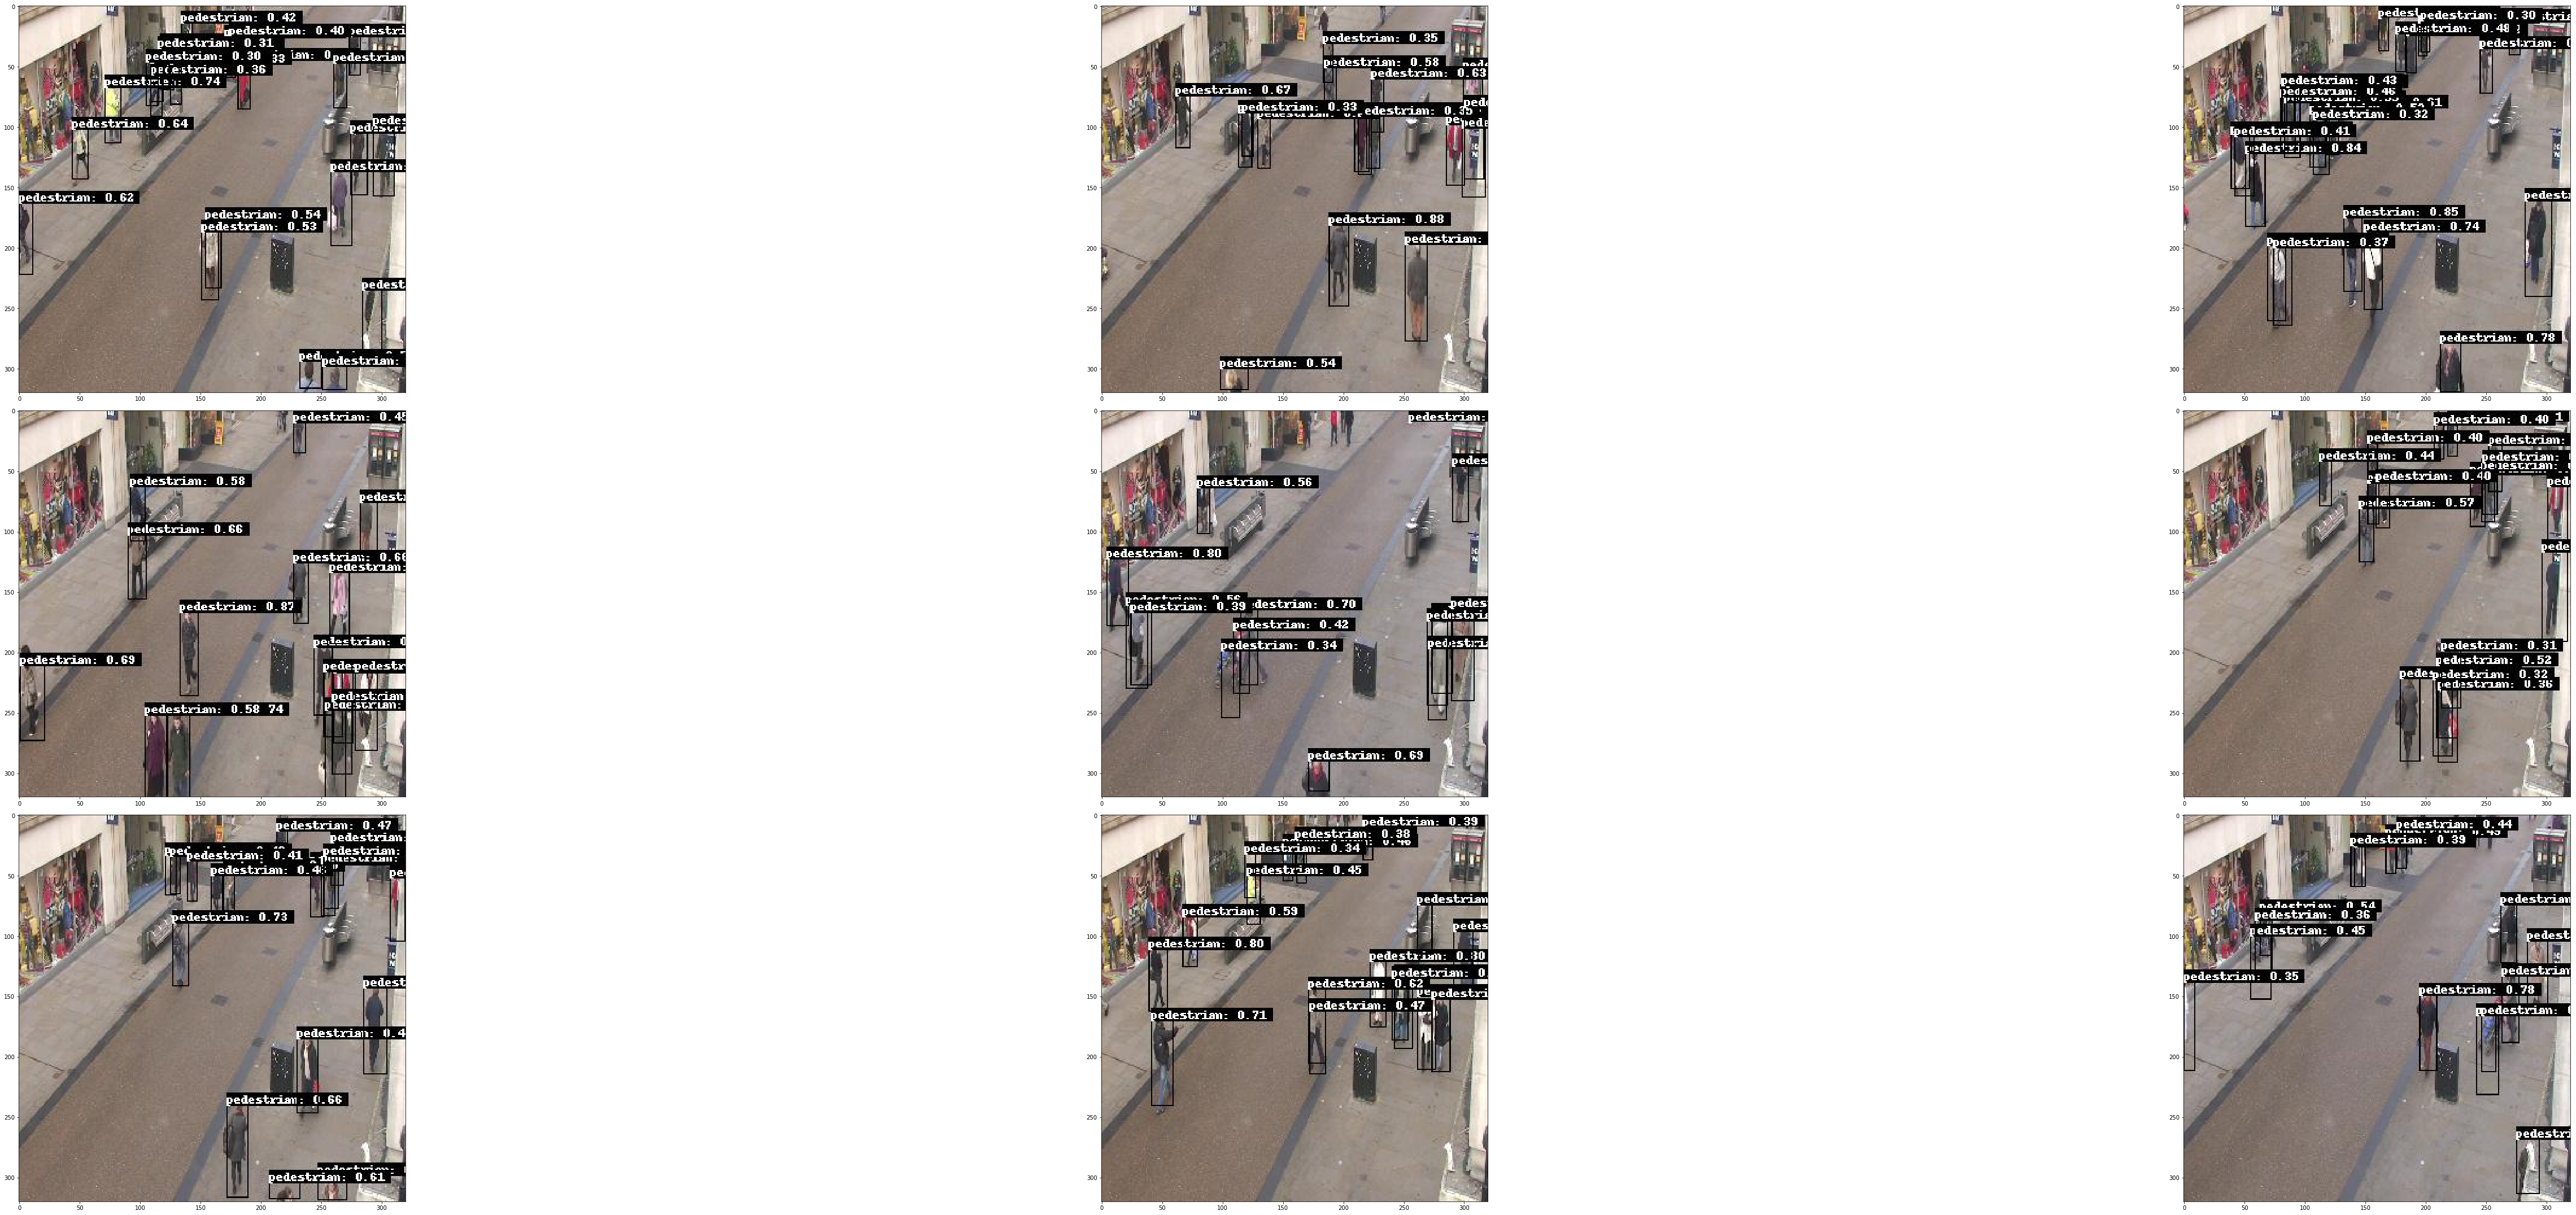

In [68]:
# Visualizing the sample images.
OUTPUT_PATH = 'ssd_infer_images' # relative path from $USER_EXPERIMENT_DIR.
COLS = 3 # number of columns in the visualizer grid.
IMAGES = 9 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

## 9. Deploy! <a class="anchor" id="head-9"></a>

In [69]:
!mkdir -p $USER_EXPERIMENT_DIR/export
# Export in FP32 mode. Change --data_type to fp16 for FP16 mode
!tlt-export ssd -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
                -k $KEY \
                -o $USER_EXPERIMENT_DIR/export/ped_ssd_mobilenet_v2_epoch_$EPOCH.etlt \
                -e $SPECS_DIR/ped_ssd_mobilenet_v2_retrain.txt \
                --batch_size 1 \
                --data_type fp16

# Uncomment to export in INT8 mode (generate calibration cache file). \
# !tlt-export ssd -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt  \
#                 -o $USER_EXPERIMENT_DIR/export/ped_ssd_mobilenet_v2_epoch_$EPOCH.etlt \
#                 -e $SPECS_DIR/ped_ssd_mobilenet_v2_retrain.txt \
#                 -k $KEY \
#                 --cal_image_dir  $USER_EXPERIMENT_DIR/data/testing/image_2 \
#                 --data_type int8 \
#                 --batch_size 1 \
#                 --batches 10 \
#                 --cal_cache_file $USER_EXPERIMENT_DIR/export/cal.bin  \
#                 --cal_data_file $USER_EXPERIMENT_DIR/export/cal.tensorfile

Using TensorFlow backend.
2020-05-19 21:26:16,396 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /repo/training/tlt/specs/ped_ssd_mobilenet_v2_retrain.txt
2020-05-19 21:26:19,050 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /repo/training/tlt/specs/ped_ssd_mobilenet_v2_retrain.txt
NOTE: UFF has been tested with TensorFlow 1.14.0.
Converting NMS as custom op: NMS_TRT
Converting FirstDimTile_5 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_4 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_3 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_2 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_1 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_0 as custom op: BatchTilePlugin_TRT
DEBUG [/usr/lib/python2.7/dist-packages/uff/converters/tensorflow/converter.py:96] Marking ['NMS'] as outputs
[TensorRT] INFO: Detected 1 inputs and 2 outp

`Note:` In this example, for ease of execution we restrict the number of calibrating batches to 10. TLT recommends the use of at least 10% of the training dataset for int8 calibration.

In [70]:
print('Exported model:')
print('------------')
!ls -lh $USER_EXPERIMENT_DIR/export

Exported model:
------------
total 3.3M
-rw-r--r-- 1 root root 3.3M May 19 21:26 ped_ssd_mobilenet_v2_epoch_035.etlt


#### You can use this `.etlt` file directly in DeepStream or first create a `Tensor RT Engine` and then use the `engine` in DeepStream